In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np


In [3]:

# -------- Step 1. Load dataset --------
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:

# -------- Step 2. Separate features and target --------
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)


In [5]:
# -------- Step 3. Define pipelines --------
numerical_cols = housing.drop("ocean_proximity", axis=1).columns.tolist()
categorical_cols = ["ocean_proximity"]

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [6]:


# -------- Step 4. Fine-tuning algorithms (Random Search and Grid Search) --------
# 4.1 Linear Regression (No hyperparameters to tune, just for comparison)
linear_regression_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('model', LinearRegression())
])

# Fit and evaluate without CV
linear_regression_pipeline.fit(housing, housing_labels)
predictions = linear_regression_pipeline.predict(housing)
linear_mse = mean_squared_error(housing_labels, predictions)
linear_rmse_no_cv = np.sqrt(linear_mse)

# Evaluate with 5-fold CV
linear_scores = cross_val_score(linear_regression_pipeline, housing, housing_labels, scoring="neg_mean_squared_error", cv=5)
linear_rmse_cv = np.sqrt(-linear_scores.mean())
print(f"Linear Regression RMSE (No CV): {linear_rmse_no_cv}")
print(f"Linear Regression RMSE (With CV): {linear_rmse_cv}")






Linear Regression RMSE (No CV): 68709.57959129181
Linear Regression RMSE (With CV): 68826.34663695763


In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Step 1: Define a Ridge regression pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('model', Ridge())  # Replace LinearRegression with Ridge
])

# Step 2: Define hyperparameter grids for Random Search and Grid Search
param_grid_ridge = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]  # Grid search with alpha values
}

param_random_ridge = {
    'model__alpha': np.logspace(-3, 3, 10)  # Random search with alpha values
}

# Step 3: Perform Random Search CV
random_search_ridge = RandomizedSearchCV(ridge_pipeline, param_random_ridge, scoring='neg_mean_squared_error', cv=5, n_iter=10)
random_search_ridge.fit(housing, housing_labels)
ridge_rmse_random_search = np.sqrt(-random_search_ridge.best_score_)
print("Ridge RMSE (Random Search):", ridge_rmse_random_search)
print("Best Ridge Parameters (Random Search):", random_search_ridge.best_params_)

# Step 4: Perform Grid Search CV
grid_search_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, scoring='neg_mean_squared_error', cv=5)
grid_search_ridge.fit(housing, housing_labels)
ridge_rmse_grid_search = np.sqrt(-grid_search_ridge.best_score_)
print("Ridge RMSE (Grid Search):", ridge_rmse_grid_search)
print("Best Ridge Parameters (Grid Search):", grid_search_ridge.best_params_)


Ridge RMSE (Random Search): 68827.71076214
Best Ridge Parameters (Random Search): {'model__alpha': 0.001}
Ridge RMSE (Grid Search): 68827.71485306349
Best Ridge Parameters (Grid Search): {'model__alpha': 0.01}


In [7]:
# 4.2 Decision Tree Fine-Tuning
decision_tree_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Random Search for Decision Tree
param_distributions_tree = {
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 10, 20],
    'model__min_samples_leaf': [1, 5, 10]
}

random_search_tree = RandomizedSearchCV(decision_tree_pipeline, param_distributions_tree, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)
random_search_tree.fit(housing, housing_labels)
best_tree_model = random_search_tree.best_estimator_
tree_rmse_random_search = np.sqrt(-random_search_tree.best_score_)
print("Decision Tree RMSE (Random Search):", tree_rmse_random_search)
print("Best Decision Tree Parameters (Random Search):", random_search_tree.best_params_)

# Grid Search for Decision Tree
param_grid_tree = {
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid_search_tree = GridSearchCV(decision_tree_pipeline, param_grid_tree, scoring='neg_mean_squared_error', cv=5)
grid_search_tree.fit(housing, housing_labels)
tree_rmse_grid_search = np.sqrt(-grid_search_tree.best_score_)
print("Decision Tree RMSE (Grid Search):", tree_rmse_grid_search)
print("Best Decision Tree Parameters (Grid Search):", grid_search_tree.best_params_)


Decision Tree RMSE (Random Search): 57894.324009629185
Best Decision Tree Parameters (Random Search): {'model__min_samples_split': 10, 'model__min_samples_leaf': 10, 'model__max_depth': 40}
Decision Tree RMSE (Grid Search): 60967.09569686353
Best Decision Tree Parameters (Grid Search): {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}


In [8]:
# 4.3 Random Forest Fine-Tuning
random_forest_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('model', RandomForestRegressor(random_state=42))
])

# Random Search for Random Forest

param_distributions_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5],
    'model__max_features': ['sqrt', 'log2']  # Removed 'auto'
}

random_search_rf = RandomizedSearchCV(random_forest_pipeline, param_distributions_rf, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)
random_search_rf.fit(housing, housing_labels)
best_rf_model = random_search_rf.best_estimator_
rf_rmse_random_search = np.sqrt(-random_search_rf.best_score_)
print("Random Forest RMSE (Random Search):", rf_rmse_random_search)
print("Best Random Forest Parameters (Random Search):", random_search_rf.best_params_)


# Grid Search for Random Forest
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_features': ['auto', 'sqrt'],
    'model__max_depth': [None, 10, 20]
}

grid_search_rf = GridSearchCV(random_forest_pipeline, param_grid_rf, scoring='neg_mean_squared_error', cv=5)
grid_search_rf.fit(housing, housing_labels)
rf_rmse_grid_search = np.sqrt(-grid_search_rf.best_score_)
print("Random Forest RMSE (Grid Search):", rf_rmse_grid_search)
print("Best Random Forest Parameters (Grid Search):", grid_search_rf.best_params_)

Random Forest RMSE (Random Search): 49684.82198011207
Best Random Forest Parameters (Random Search): {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 30}


C:\Anaconda\envs\homl3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda\envs\homl3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\homl3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Anaconda\envs\homl3\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\envs\h

Random Forest RMSE (Grid Search): 49430.90138157571
Best Random Forest Parameters (Grid Search): {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__n_estimators': 200}


In [10]:
# 4.4 Support Vector Regressor (SVR) Fine-Tuning
svr_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('model', SVR())
])

# Random Search for SVR
param_distributions_svr = {
    'model__C': [0.1, 1, 10],
    'model__epsilon': [0.1, 0.2, 0.5],
    'model__kernel': ['linear', 'rbf']
}

random_search_svr = RandomizedSearchCV(svr_pipeline, param_distributions_svr, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)
random_search_svr.fit(housing, housing_labels)
best_svr_model = random_search_svr.best_estimator_
# Use 'best_score_' instead of 'best_score()'
svr_rmse_random_search = np.sqrt(-random_search_svr.best_score_)
print("SVR RMSE (Random Search):", svr_rmse_random_search)
print("Best SVR Parameters (Random Search):", random_search_svr.best_params_)


# Grid Search for SVR
param_grid_svr = {
    'model__C': [1, 10],
    'model__epsilon': [0.1, 0.2],
    'model__kernel': ['linear', 'rbf']
}

grid_search_svr = GridSearchCV(svr_pipeline, param_grid_svr, scoring='neg_mean_squared_error', cv=5)
grid_search_svr.fit(housing, housing_labels)
svr_rmse_grid_search = np.sqrt(-grid_search_svr.best_score_)
print("SVR RMSE (Grid Search):", svr_rmse_grid_search)
print("Best SVR Parameters (Grid Search):", grid_search_svr.best_params_)

SVR RMSE (Random Search): 81705.94007451611
Best SVR Parameters (Random Search): {'model__kernel': 'linear', 'model__epsilon': 0.5, 'model__C': 10}
SVR RMSE (Grid Search): 81705.94392795562
Best SVR Parameters (Grid Search): {'model__C': 10, 'model__epsilon': 0.2, 'model__kernel': 'linear'}


<Figure size 1200x600 with 0 Axes>

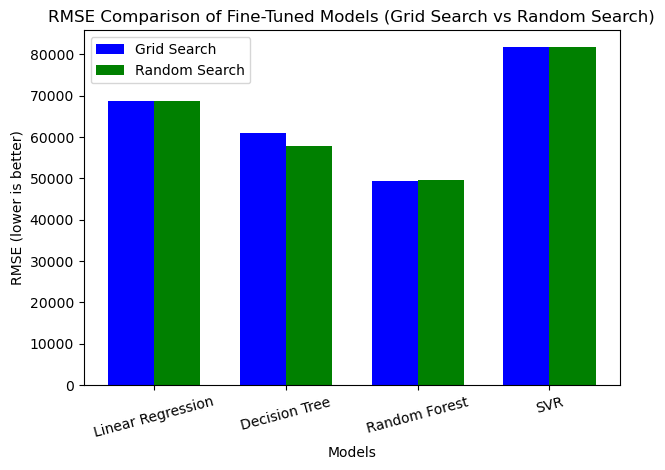

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# RMSE values for both Grid Search and Random Search
rmse_values_grid = {
    'Linear Regression': ridge_rmse_grid_search,
    'Decision Tree': tree_rmse_grid_search,
    'Random Forest': rf_rmse_grid_search,
    'SVR': svr_rmse_grid_search
}

rmse_values_random = {
    'Linear Regression': ridge_rmse_random_search,
    'Decision Tree': tree_rmse_random_search,
    'Random Forest': rf_rmse_random_search,
    'SVR': svr_rmse_random_search
}

# Model names and corresponding RMSE values for both searches
model_names = list(rmse_values_grid.keys())
rmse_scores_grid = list(rmse_values_grid.values())
rmse_scores_random = list(rmse_values_random.values())

# Step 2: Create side-by-side bar plot
x = np.arange(len(model_names))  # the label locations
width = 0.35  # width of the bars

plt.figure(figsize=(12, 6))
fig, ax = plt.subplots()

# Bar plot for Grid Search
bars_grid = ax.bar(x - width/2, rmse_scores_grid, width, label='Grid Search', color='blue')

# Bar plot for Random Search
bars_random = ax.bar(x + width/2, rmse_scores_random, width, label='Random Search', color='green')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('RMSE (lower is better)')
ax.set_title('RMSE Comparison of Fine-Tuned Models (Grid Search vs Random Search)')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=15)
plt.tight_layout()

# Show the plot
plt.show()


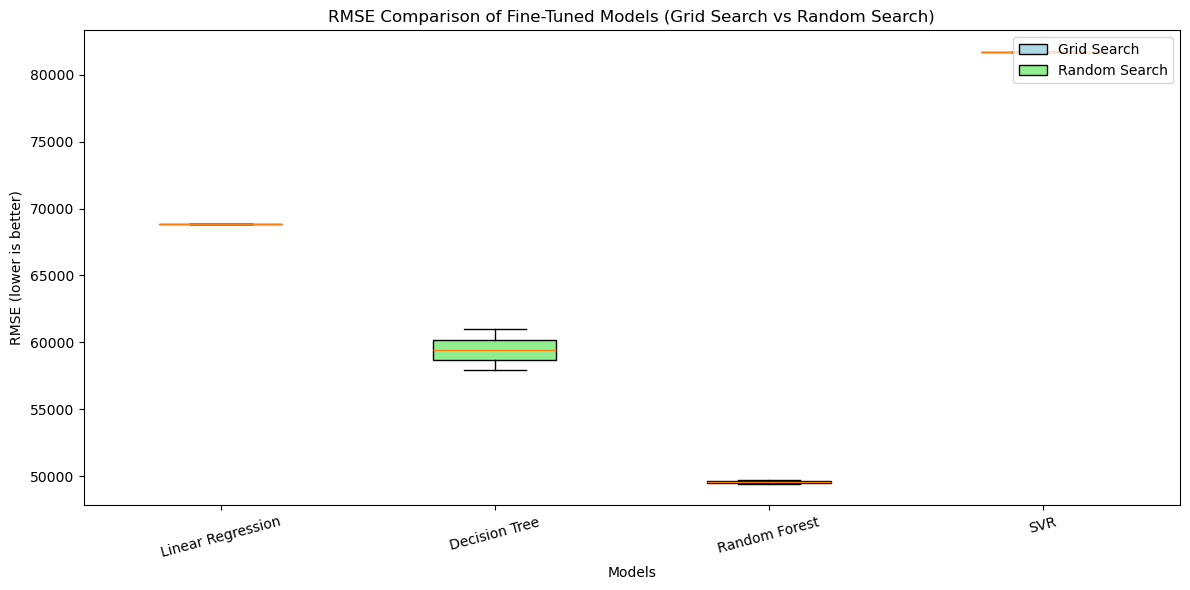

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# RMSE values for both Grid Search and Random Search
rmse_values_grid = {
    'Linear Regression': linear_rmse_cv,
    'Decision Tree': tree_rmse_grid_search,
    'Random Forest': rf_rmse_grid_search,
    'SVR': svr_rmse_grid_search
}

rmse_values_random = {
    'Linear Regression': linear_rmse_cv,
    'Decision Tree': tree_rmse_random_search,
    'Random Forest': rf_rmse_random_search,
    'SVR': svr_rmse_random_search
}

# Model names and corresponding RMSE values for both searches
model_names = list(rmse_values_grid.keys())
rmse_scores_grid = list(rmse_values_grid.values())
rmse_scores_random = list(rmse_values_random.values())

# Combine the Grid Search and Random Search RMSE values for each model
rmse_data_combined = []
for grid, random in zip(rmse_scores_grid, rmse_scores_random):
    rmse_data_combined.append([grid, random])

# Create the box plot
plt.figure(figsize=(12, 6))

# Create the box plots for each model
box = plt.boxplot(rmse_data_combined, patch_artist=True, labels=model_names)

# Color customization for box plots
colors = ['lightblue', 'lightgreen']
for i in range(len(box['boxes'])):
    box['boxes'][i].set_facecolor(colors[i % 2])  # Alternate colors for Grid and Random

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('RMSE (lower is better)')
plt.title('RMSE Comparison of Fine-Tuned Models (Grid Search vs Random Search)')

# Add legend
plt.legend([box['boxes'][0], box['boxes'][1]], ['Grid Search', 'Random Search'], loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=15)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
#Evaluation Test data set

In [25]:
def evaluate_model_on_test(model, test_data, test_labels):
    predictions = model.predict(test_data)
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse)
    return rmse


In [26]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
housing_train, housing_test, housing_labels_train, housing_labels_test = train_test_split(
    housing, housing_labels, test_size=0.2, random_state=42)


In [28]:
# Evaluate Ridge (Best from Random Search) on the Test Set
ridge_rmse_test_random = evaluate_model_on_test(random_search_ridge.best_estimator_, housing_test, housing_labels_test)
print("Ridge RMSE (Random Search) on Test Set:", ridge_rmse_test_random)

# Evaluate Ridge (Best from Grid Search) on the Test Set
ridge_rmse_test_grid = evaluate_model_on_test(grid_search_ridge.best_estimator_, housing_test, housing_labels_test)
print("Ridge RMSE (Grid Search) on Test Set:", ridge_rmse_test_grid)


Ridge RMSE (Random Search) on Test Set: 69635.53649536314
Ridge RMSE (Grid Search) on Test Set: 69635.54256959811


In [29]:
# Evaluate Decision Tree (Random Search) on Test Set
tree_rmse_test_random_search = evaluate_model_on_test(best_tree_model, housing_test, housing_labels_test)
print("Decision Tree RMSE (Random Search, Test Set):", tree_rmse_test_random_search)

# Evaluate Decision Tree (Grid Search) on Test Set
tree_rmse_test_grid_search = evaluate_model_on_test(grid_search_tree.best_estimator_, housing_test, housing_labels_test)
print("Decision Tree RMSE (Grid Search, Test Set):", tree_rmse_test_grid_search)


Decision Tree RMSE (Random Search, Test Set): 44006.79782774809
Decision Tree RMSE (Grid Search, Test Set): 49475.26018178012


In [30]:
# Evaluate Random Forest (Random Search) on Test Set
rf_rmse_test_random_search = evaluate_model_on_test(best_rf_model, housing_test, housing_labels_test)
print("Random Forest RMSE (Random Search, Test Set):", rf_rmse_test_random_search)

# Evaluate Random Forest (Grid Search) on Test Set
rf_rmse_test_grid_search = evaluate_model_on_test(grid_search_rf.best_estimator_, housing_test, housing_labels_test)
print("Random Forest RMSE (Grid Search, Test Set):", rf_rmse_test_grid_search)


Random Forest RMSE (Random Search, Test Set): 24563.570498209672
Random Forest RMSE (Grid Search, Test Set): 18255.85351733152


In [31]:
# Evaluate SVR (Random Search) on Test Set
svr_rmse_test_random_search = evaluate_model_on_test(best_svr_model, housing_test, housing_labels_test)
print("SVR RMSE (Random Search, Test Set):", svr_rmse_test_random_search)

# Evaluate SVR (Grid Search) on Test Set
svr_rmse_test_grid_search = evaluate_model_on_test(grid_search_svr.best_estimator_, housing_test, housing_labels_test)
print("SVR RMSE (Grid Search, Test Set):", svr_rmse_test_grid_search)


SVR RMSE (Random Search, Test Set): 82560.47623108755
SVR RMSE (Grid Search, Test Set): 82560.49551890402


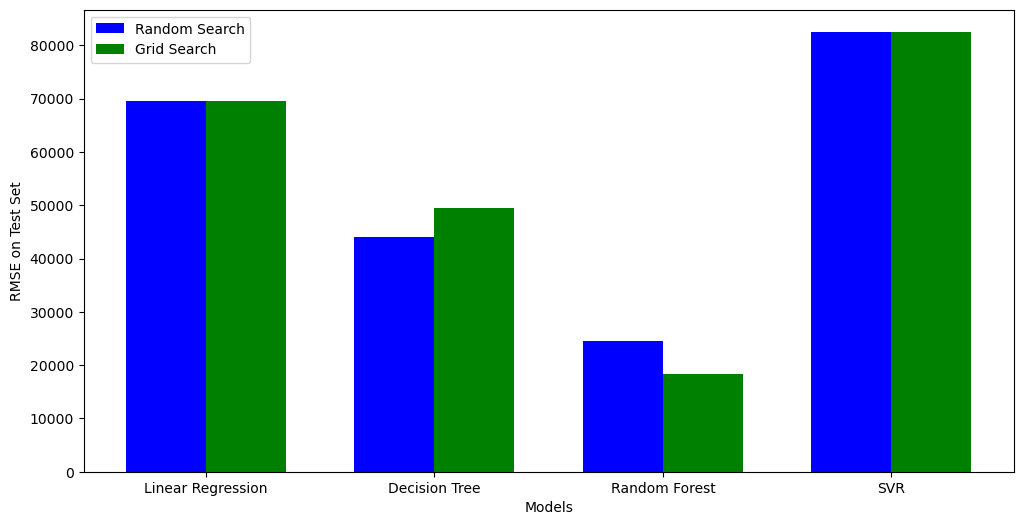

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# RMSE values for Random Search and Grid Search on the test set
rmse_random_search = {
    'Linear Regression': ridge_rmse_test_random,  # No tuning for Linear Regression
    'Linear Regression': ridge_rmse_test_random,  
    'Decision Tree': tree_rmse_test_random_search,
    'Random Forest': rf_rmse_test_random_search,
    'SVR': svr_rmse_test_random_search
}

rmse_grid_search = {
    'Linear Regression': ridge_rmse_test_grid,  
    'Decision Tree':tree_rmse_test_grid_search,
    'Random Forest': rf_rmse_test_grid_search,
    'SVR': svr_rmse_test_grid_search
}

# Model names
models = list(rmse_random_search.keys())

# Creating a plot for both methods
x = np.arange(len(models))  # Label locations
width = 0.35  # Bar width

# Plotting the bars
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, rmse_random_search.values(), width, label='Random Search', color='blue')
bars2 = ax.bar(x + width/2, rmse_grid_search.values(), width, label='Grid Search', color='green')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('RMSE on Test Set')
#ax.set_title('Comparison of RMSE on Test Set(Random Search vs Grid Search)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.show()
